Был запущен сплит-тест (а/б-тест), направленный на улучшение платежной активности пользователей. Вам дан датасет с транзакциями пользователей до и во время теста в контрольной и тестовых группах

1. Какие вы можете сделать выводы? Какая группа показала лучшие результаты?
2. Можем ли мы как-то оценить из этих данных равномерность и валидность распределения юзеров по разным группам?
3. Если не ограничиваться теми данными, которые приведены в рамках этого задания, что ещё вы бы посчитали для оценки результатов групп?

**Описание данных:**

В таблице users_ приведена информация о том, какой юзер в какой момент времени попал в а/б тест:
- tag - лэйбл группы (control - контрольная, остальные - тестовые)
- ts - время, когда впервые был выдан tag. То есть, все события до наступления времени ts происходили с юзером до попадания в а/б тест
- user_uid - внутренний id юзера (для матчинга со второй таблицей)
- registration_time - время регистрации пользователя в сервисе
- conv_ts - время совершения первой покупки пользователем в сервисе

В таблице purchases_ приведена информация о транзакциях пользователей из таблицы users_ до и во время а/б теста:
- user_uid - внутренний id юзера (для матчинга со второй таблицей)
- time - время совершения транзакции
- consumption_mode - вид потребления контента (dto - единица контента куплена навсегда, rent - единица контента взята в аренду, subscription - оформлена подписка)
- element_uid - уникальный id единицы контента или подписки
- price - цена (преобразованная)

Значения в полях price и всех полях, указывающих на время - преобразованы. Это значит, что значение в таблице не настоящее, но является линейным преобразованием реального значения, где ко всем значениям одного поля применено одно и то же преобразование - между ними сохранено отношение порядка. Ко всем полям, обозначающим время, применено одно и то же преобразование.

# Выводы

## 1. Какие вы можете сделать выводы? Какая группа показала лучшие результаты?

Тест показал стат значимые различия между контрольной группой и 2 тестовыми группами: test_2 и test_3

Тестовая группа №3 показала лучшие резульатаы по среднему ARPU:
69.59 рубля против 68.34 рубля в контрольной

Между средними test_2 и test_3 статистической значимости не обнаружилось. Это стоит учесть, если изменения, как для 2ой группы, проще реализовать


## 2. Можем ли мы как-то оценить из этих данных равномерность и валидность распределения юзеров по разным группам?

Пользователи распределились по группам неравномерно. Неравномерность распределения была проверена критерием Хи-квадрат 

Всего 155104 пользователя совершили покупки после деления их на группы. 22% пользователей сервиса от общего числа приняли участие в тестировании.

## 3. Если не ограничиваться теми данными, которые приведены в рамках этого задания, что ещё вы бы посчитали для оценки результатов групп?

Интересно углубиться в анализ и попытаться выделить сегменты аудитории внутри сервиса. Посмотреть на такие характеристики как: платформа, пол, возраст. Возможно, на какие-то группы пользователей эксперимент оказал бóльшее влияние

In [1]:
# Необходимые библиотеки для исследования 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [3]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(16,6)}
        )

In [4]:
#информация о том, какой юзер в какой момент времени попал в а/б тест
users = pd.read_csv('/Users/gaidovski/Downloads/Архив/users_.csv')
users.head()

,tag,ts,user_uid,registration_time,conv_ts
0,test4,30152.843868,001885550d78efd82c0f5cc02ad3369a,27410.154590,29485.529691
1,control,30133.146255,deb7d0e9bf9813d4f21b579d3703c6e1,27410.171795,27632.424734
2,test1,30140.447675,32095e22f853e595a0f407ad081e7da8,27410.217536,27414.028899
3,control,30136.790772,9932d33f40ad07d7f3ddb7c6aee1bc60,27410.227367,27573.751226
4,test2,30150.339264,4a122db1ad0214e969df154d2dbb4622,27410.230786,29545.833019


In [5]:
users.isna().sum()

tag                    0
ts                     0
user_uid               0
registration_time    497
conv_ts              285
dtype: int64

In [6]:
users.dtypes

tag                   object
ts                   float64
user_uid              object
registration_time    float64
conv_ts              float64
dtype: object

In [7]:
users.shape
print(f"{users.shape[0]} количество строк")

696982 количество строк


In [8]:
print(f"{users.user_uid.nunique()} уникальных пользователей")

694819 уникальных пользователей


**Комментарий**


Заметим, что количество строк в users больше, чем уникальных пользователей.
Посмотрим на уникальные id. Не было ли такого, что один пользователь попал в разные группы

In [9]:
dupl = users.groupby('user_uid', as_index=False).agg({'registration_time':'count'}) \
.sort_values(by='registration_time', ascending=False).rename(columns={"registration_time": "number_of_tags"})
dupl['more_than_one'] = dupl.number_of_tags >= 2
dupl.head()

,user_uid,number_of_tags,more_than_one
293127,6c2289ccfa50dd5b669b159fe12ca4ed,4,True
496483,b6c9ba2b342248e18633b95d9fc1333d,4,True
104462,26890a8487248806518c97c316ba1d05,4,True
135286,31cf96417ebb6203179673d11c225e25,3,True
345378,7f38b31f238a990d60162f56d5032af3,3,True


**Комментарий**

Видим, что некоторым пользователям тэг был присвоен несколько раз.
Посмотрим, что именно происходило с первым пользователем по количеству присвоенных тэгов

In [10]:
users.query("user_uid == '6c2289ccfa50dd5b669b159fe12ca4ed'").sort_values(by='ts', ascending=False)

,tag,ts,user_uid,registration_time,conv_ts
97224,test4,30140.554481,6c2289ccfa50dd5b669b159fe12ca4ed,28692.364445,28906.943711
90820,test3,30136.593332,6c2289ccfa50dd5b669b159fe12ca4ed,28692.364445,28906.943711
103896,control,30136.492787,6c2289ccfa50dd5b669b159fe12ca4ed,28692.364445,28906.943711
93037,test3,30133.872325,6c2289ccfa50dd5b669b159fe12ca4ed,28692.364445,28906.943711


In [11]:
print(f"{dupl.more_than_one.sum()} пользователям был присвоен тэг больше 1 раза")

2084 пользователям был присвоен тэг больше 1 раза


In [12]:
dupl.query("more_than_one == True").number_of_tags.sum()

4234

In [13]:
users.shape[0] - dupl.query("more_than_one == True").number_of_tags.sum() + dupl.more_than_one.sum()

694832

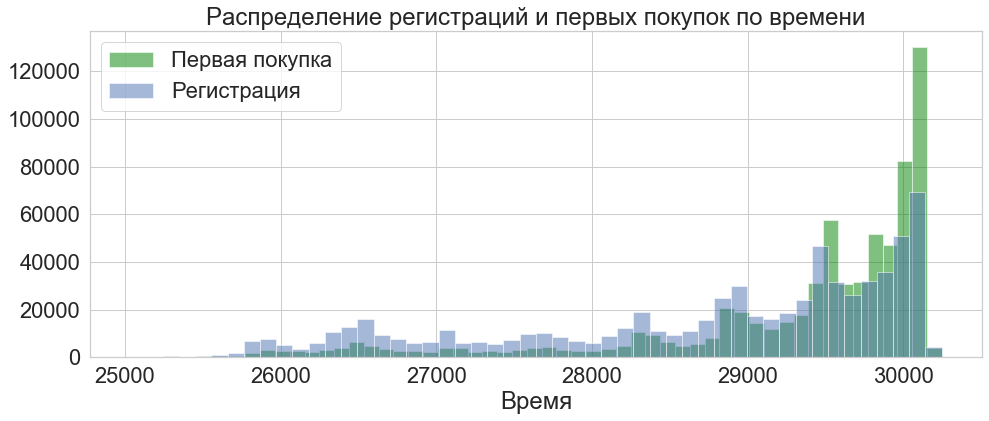

In [14]:
users.conv_ts.hist(alpha=0.5, color='green', bins=50, label='Первая покупка')
users.registration_time.hist(alpha=0.5, bins=50, label="Регистрация")

#plt.xticks(rotation=90) 
plt.title('Распределение регистраций и первых покупок по времени')
plt.xlabel('Время')
plt.legend();

**Комментарий**

Видим, что после условного времени 29000 произошел рост числа регистраций

In [15]:
#данные о транзакциях пользователей из таблицы users_ до и во время а/б теста:
purchases = pd.read_csv('/Users/gaidovski/Downloads/Архив/purchases_.csv', sep=',')
purchases['price'] = purchases.price.round(1)
purchases.head()

,user_uid,time,consumption_mode,element_uid,price
0,d60a7038c7b7e99146ffea6f6535862b,30158.645112,dto,2ba66ac9785731da67b2b6155efaca5c,44.5
1,0906074e1a1a9229b5e749860b646962,30158.645015,dto,e56d422275d90c96762f81db85d80f3d,38.6
2,efb6eeca3135d573739e5c5d4dbce330,30158.644990,dto,544f7dd31bd61558c9c738adcff6aafa,50.4
3,ccd658e372645c991ce49b444839712f,30158.644789,dto,8256d0fc7b25382aacfec0066e39cde3,44.5
4,89ae5e43ff7b89f9d262d507dedc1760,30158.644200,dto,a579f32b5c116624cc661c9d3b96d5e5,44.5


In [16]:
purchases.shape

(663849, 5)

In [17]:
purchases.isna().sum()

user_uid            0
time                0
consumption_mode    0
element_uid         0
price               0
dtype: int64

In [18]:
purchases.dtypes

user_uid             object
time                float64
consumption_mode     object
element_uid          object
price               float64
dtype: object

In [19]:
print(f"{purchases.user_uid.nunique()} уникальных пользователей")

295200 уникальных пользователей


In [20]:
#зададим отдельную таблицу по количеству транзакций
number_of_purchases = purchases.groupby('user_uid',as_index=False).agg({'time':'count'}) \
.rename(columns={"time": "number_of_purchases"}) \
.sort_values(by='number_of_purchases', ascending=False)
#посмотрим на описантельные статистики покупок пользователей
number_of_purchases.describe()

,number_of_purchases
count,295200.000000
mean,2.248811
std,2.181822
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,60.000000


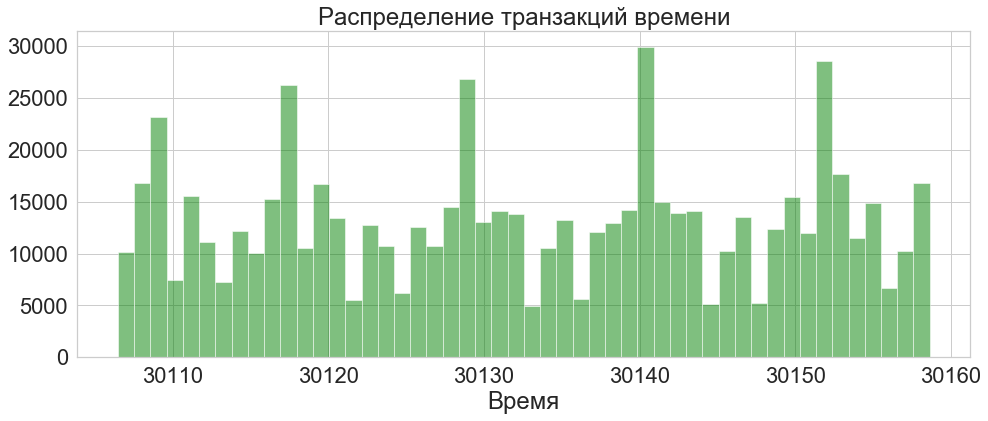

In [21]:
#посмотрим на распределение по времени
purchases.time.hist(alpha=0.5, color='green', bins=50)

plt.title('Распределение транзакций времени')
plt.xlabel('Время');

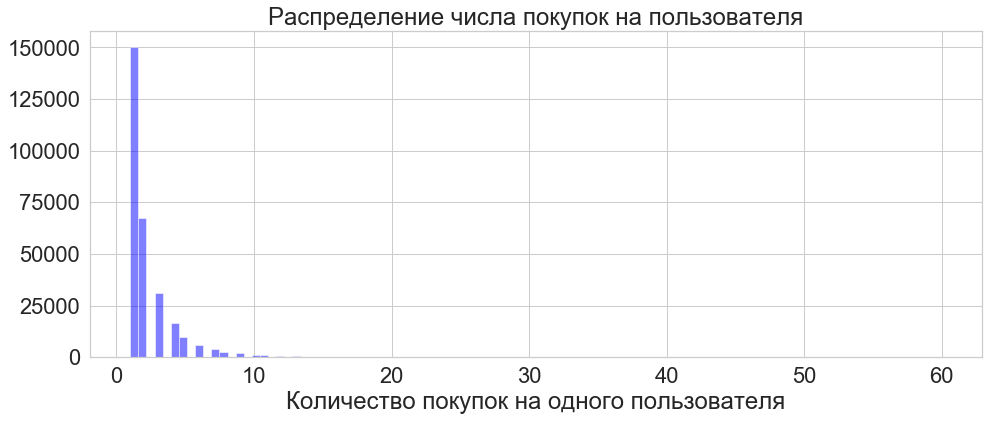

In [22]:
number_of_purchases.number_of_purchases.hist(alpha=0.5, color='blue', bins=100)

plt.title('Распределение числа покупок на пользователя')
plt.xlabel('Количество покупок на одного пользователя');

**Комментарий**

- В среднем пользователи совершили 2.2 транзакции за расмотренный условный период 
- 25% пользователей совершили 3 и более транзакции
- Максимальное количество покупок на одного юзера - 60
- Большинство пользователей совершили 1 покупку
- Распределение покупок по времени имеет явную цикличность (возможно, по дня недели)

In [23]:
#количество приобретений контента по виду потребления контента
popular_consumption_mode = purchases.pivot_table(index = 'consumption_mode', values = 'user_uid', 
                        aggfunc = 'count', fill_value=0).reset_index() \
.rename(columns={"user_uid": "number_of_transactions"}) \
.sort_values(by='number_of_transactions', ascending=False)
popular_consumption_mode.head()

,consumption_mode,number_of_transactions
0,dto,245276
2,subscription,239897
1,rent,178676


In [24]:
purchases.pivot_table(index = 'consumption_mode', values = 'price', 
                        aggfunc = 'mean', fill_value=0).reset_index() \
#.rename(columns={"user_uid": "number_of_transactions"}) \
#.sort_values(by='number_of_transactions', ascending=False)

,consumption_mode,price
0,dto,34.932015
1,rent,27.813484
2,subscription,45.810324


In [25]:
#количество транзакций, средняя цена и выручка по каждому виду потребления
consumption_mode = purchases.groupby('consumption_mode', as_index=False) \
.agg({'time':'count','price':'mean'}) \
.rename(columns={"time": "number_of_transactions", 'price':'mean_price'})
consumption_mode['revenue'] = consumption_mode.number_of_transactions * consumption_mode.mean_price
consumption_mode = consumption_mode.sort_values(by='revenue', ascending=False)
consumption_mode['share_of_revenue'] = consumption_mode.revenue / consumption_mode.revenue.sum()
consumption_mode['share_of_transactions'] = consumption_mode.number_of_transactions / consumption_mode.number_of_transactions.sum()
round(consumption_mode,2)

,consumption_mode,number_of_transactions,mean_price,revenue,share_of_revenue,share_of_transactions
2,subscription,239897,45.81,10989759.4,0.45,0.36
0,dto,245276,34.93,8567984.9,0.35,0.37
1,rent,178676,27.81,4969602.0,0.20,0.27


- "Подписка" принесла 45% выручки за расмотренный период 
- Так же подписка - самый дорогой вид потребления. Средняя цена - 45.8
- Покупка контента и подписка почти одинаково популярны 37% и 36% соответсвенно
- Меньше всего клиенты сервиса пользовались "арендой". Так же аренда контента внесла наименьший вклад в выручку сервиса 20%


In [26]:
#общая таблица
us_pur = purchases.merge(users, on='user_uid')

In [27]:
#оставим транзакции, которые были совершены после определения тэга для юзера
us_pur_ab = us_pur.query("time > ts")
us_pur_ab.head()

,user_uid,time,consumption_mode,element_uid,price,tag,ts,registration_time,conv_ts
0,d60a7038c7b7e99146ffea6f6535862b,30158.645112,dto,2ba66ac9785731da67b2b6155efaca5c,44.5,control,30145.756945,29592.948988,29593.097789
1,d60a7038c7b7e99146ffea6f6535862b,30157.124337,dto,5aa724c0393087cde3a18c625b310645,44.5,control,30145.756945,29592.948988,29593.097789
2,d60a7038c7b7e99146ffea6f6535862b,30153.692015,dto,d1ad6ec9f3de6b15e1e2bb109885debe,38.6,control,30145.756945,29592.948988,29593.097789
3,d60a7038c7b7e99146ffea6f6535862b,30153.584597,dto,6eb3335f238dd96a0eda2608a0a76775,38.6,control,30145.756945,29592.948988,29593.097789
8,0906074e1a1a9229b5e749860b646962,30158.645015,dto,e56d422275d90c96762f81db85d80f3d,38.6,control,30137.415922,28079.984456,28078.995322


In [28]:
us_pur_ab.shape

(279550, 9)

In [29]:
sum_per_user = us_pur_ab.groupby(['user_uid', 'tag'], as_index = False) \
.agg({'price': 'sum'}).sort_values(by='tag')
sum_per_user

,user_uid,tag,price
51570,54fdabdc4738cd631baf915200249597,control,68.0
86061,8dd2b1e319c039508fbc20632ac8ef91,control,103.6
135975,e01c49bbb45c460ef54523ae3834c13e,control,68.0
38034,3eb1ade8f4d1a0c67939829fc799b5cc,control,38.6
111687,b7ef1760f48cf477036d3b24ae2b1661,control,68.0
...,...,...,...
60164,6323aa0e78d3205ce3f1846dd1ce8ea4,test4,29.8
60163,63233bd8ef4dc9a95a57837d3c792631,test4,29.8
60149,631c4b51eed6d60965368486d2e4ee27,test4,38.6
60177,6328e88330e70cf8b425a159c5f33e01,test4,197.4


In [30]:
#посчитаем ARPU и распределение пользователей по группам
groups = sum_per_user.groupby(['tag'], as_index = False).agg({'price':'mean','user_uid':'count'}). \
rename(columns={"price": "ARPU", "user_uid":"number_of_users"})
groups['test_users_share'] = groups.number_of_users / groups.number_of_users.sum()
groups = round(groups, 2)
groups.head()

,tag,ARPU,number_of_users,test_users_share
0,control,68.34,30117,0.19
1,test1,69.15,31526,0.20
2,test2,69.40,31104,0.20
3,test3,69.60,31162,0.20
4,test4,69.20,31195,0.20


**Комментарий**

- на первый взгляд пользователи по тестовым группам распределились относительно равномерно, но в контрольной группе значения сильно меньше
- проверим равномерность распределения
- наибольшее различие по ARPU у контрольной группы с test3
- сравним ARPU 

In [31]:
from scipy.stats import chisquare

In [32]:
chi_pvalue = chisquare(groups.number_of_users)[1]
print(f"p-value теста:{chisquare(groups.number_of_users)[1]}")
        
      
if 0.05 >= chi_pvalue:
    print('Отклоняем H0, пользователи распредены не равномерно по группам')
else:
    print('Не отклоняем H0, пользователи распредены равномерно по группам')

p-value теста:2.3893576849448587e-07
Отклоняем H0, пользователи распредены не равномерно по группам


In [33]:
#данные по покупкам пользователей в группах
test_1 = sum_per_user.query("tag == 'test1'")['price']
test_2 = sum_per_user.query("tag == 'test2'")['price']
test_3 = sum_per_user.query("tag == 'test3'")['price']
test_4 = sum_per_user.query("tag == 'test4'")['price']
control = sum_per_user.query("tag == 'control'")['price']

In [34]:
#boot control
boot_it = 1000
boot_data_c = []
boot_conf_level = 0.95

for i in range(boot_it):
    samples = control.sample(len(control), replace=True)
    boot_data_c.append(np.mean(samples))

print(f'Original:{round(np.mean(control),2)}, Boot: {round(np.mean(boot_data_c),2)}')

Original:68.34, Boot: 68.34


In [35]:
#boot test_1
boot_it = 1000
boot_data_1 = []
boot_conf_level = 0.95

for i in range(boot_it):
    samples = test_1.sample(len(test_1), replace=True)
    boot_data_1.append(np.mean(samples))

print(f'Original:{round(np.mean(test_1),2)}, Boot: {round(np.mean(boot_data_1),2)}')

Original:69.15, Boot: 69.15


In [36]:
#boot test_2
boot_it = 1000
boot_data_2 = []
boot_conf_level = 0.95

for i in range(boot_it):
    samples = test_2.sample(len(test_2), replace=True)
    boot_data_2.append(np.mean(samples))

print(f'Original:{round(np.mean(test_2),2)}, Boot: {round(np.mean(boot_data_2),2)}')

Original:69.4, Boot: 69.42


In [37]:
#boot test_3
boot_it = 1000
boot_data_3 = []
boot_conf_level = 0.95

for i in range(boot_it):
    samples = test_3.sample(len(test_3), replace=True)
    boot_data_3.append(np.mean(samples))

print(f'Original:{round(np.mean(test_3),2)}, Boot: {round(np.mean(boot_data_3),2)}')

Original:69.6, Boot: 69.59


In [38]:
#boot test_4
boot_it = 1000
boot_data_4 = []
boot_conf_level = 0.95

for i in range(boot_it):
    samples = test_4.sample(len(test_4), replace=True)
    boot_data_4.append(np.mean(samples))

print(f'Original:{round(np.mean(test_4),2)}, Boot: {round(np.mean(boot_data_4),2)}')

Original:69.2, Boot: 69.2


**Комментарий** 

Наибольшее среднее у test_3. Сравним контрольную группу с test_3 в первую очередь

In [39]:
left_cl = (1 - boot_conf_level) / 2
right_cl = (1 + boot_conf_level) / 2
cl_3 = pd.Series(boot_data_3).quantile([left_cl,right_cl])
cl_c = pd.Series(boot_data_c).quantile([left_cl,right_cl])

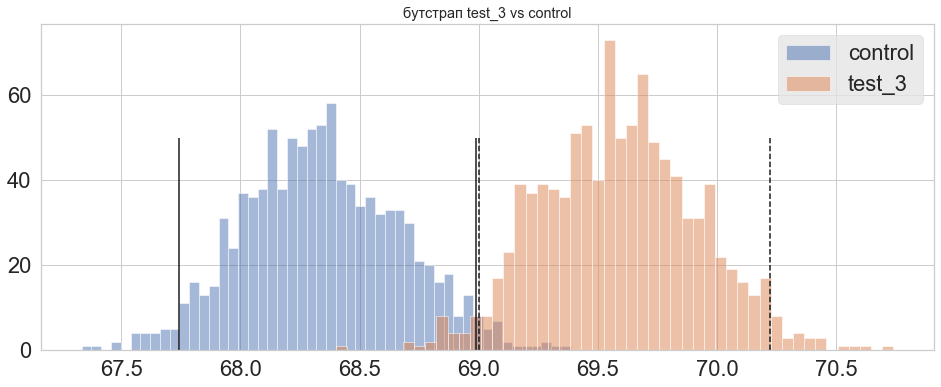

In [40]:
plt.hist(pd.Series(boot_data_c), bins=50, alpha=0.5, label='control')
plt.hist(pd.Series(boot_data_3), bins=50, alpha=0.5, label='test_3')
plt.style.use('ggplot')
plt.vlines(cl_3,ymin=0,ymax=50,linestyle='--')
plt.vlines(cl_c,ymin=0,ymax=50,linestyle='-')
plt.title('бутстрап test_3 vs control')
plt.legend();

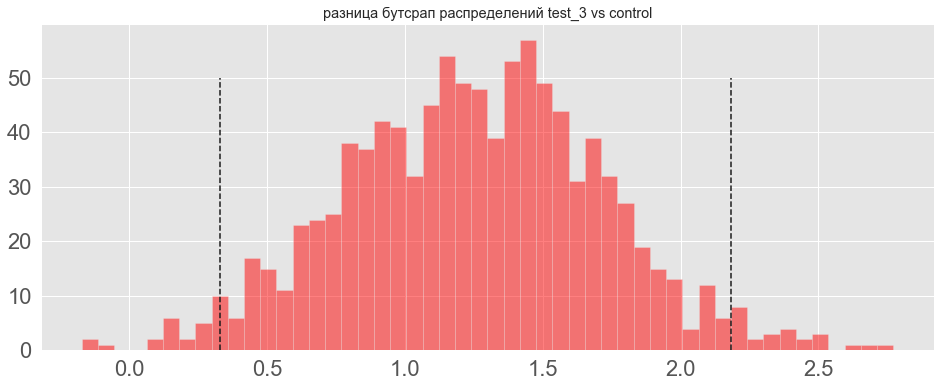

In [41]:
#разница средних бутстрап распределений test_3
cl_pvalue = pd.Series(pd.Series(boot_data_3) - pd.Series(boot_data_c)).quantile([left_cl,right_cl])
plt.hist(pd.Series(boot_data_3) - pd.Series(boot_data_c), bins=50, alpha=0.5, color='red')
plt.title('разница бутсрап распределений test_3 vs control')
plt.vlines(cl_pvalue,ymin=0,ymax=50,linestyle='--');

**Комментарий**

0 не попадает в доверительный интервал для разницы средних бутстрап распределений. Можем считать, что ARPU группы test_3  статистически значимо больше, чем у контрольной группы

In [42]:
155104 / 694819 

0.2232293590129228

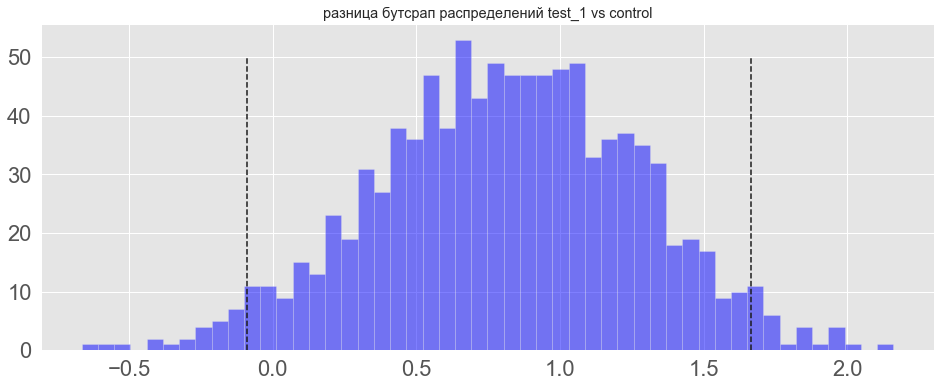

In [43]:
#разница средних бутстрап распределений test_1
cl_pvalue = pd.Series(pd.Series(boot_data_1) - pd.Series(boot_data_c)).quantile([left_cl,right_cl])
plt.hist(pd.Series(boot_data_1) - pd.Series(boot_data_c), bins=50, alpha=0.5, color='blue')
plt.title('разница бутсрап распределений test_1 vs control')
plt.vlines(cl_pvalue,ymin=0,ymax=50,linestyle='--');

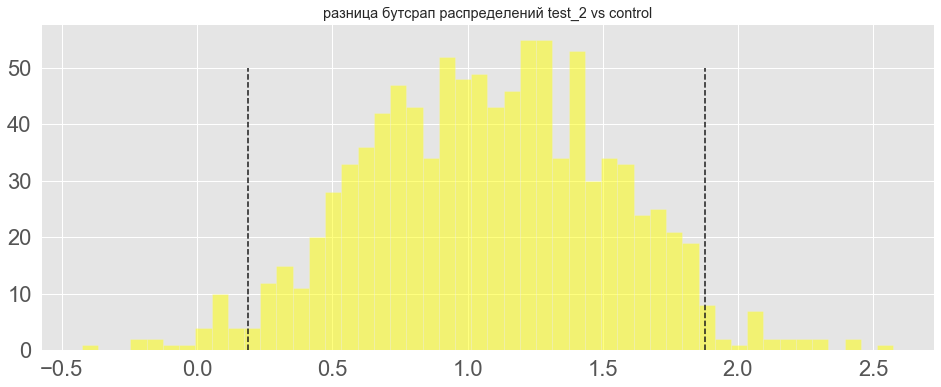

In [44]:
#разница средних бутстрап распределений test_2
cl_pvalue = pd.Series(pd.Series(boot_data_2) - pd.Series(boot_data_c)).quantile([left_cl,right_cl])
plt.hist(pd.Series(boot_data_2) - pd.Series(boot_data_c), bins=50, alpha=0.5, color='yellow')
plt.title('разница бутсрап распределений test_2 vs control')
plt.vlines(cl_pvalue,ymin=0,ymax=50,linestyle='--');

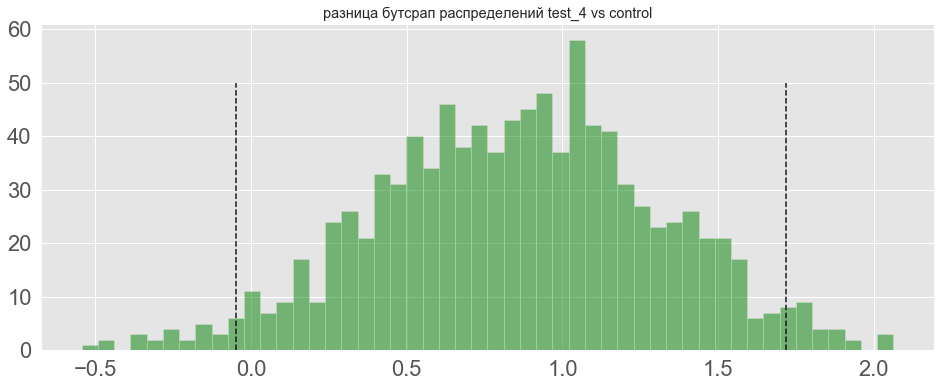

In [45]:
#разница средних бутстрап распределений test_4
cl_pvalue = pd.Series(pd.Series(boot_data_4) - pd.Series(boot_data_c)).quantile([left_cl,right_cl])
plt.hist(pd.Series(boot_data_4) - pd.Series(boot_data_c), bins=50, alpha=0.5, color='green')
plt.title('разница бутсрап распределений test_4 vs control')
plt.vlines(cl_pvalue,ymin=0,ymax=50,linestyle='--');

**Комментарий**

Статистической значимости для test_1 и test_4 в сравнении с контрольной группой не обнаружено

Но обнаружилась разница для test_2 

Сравним между собой test_2 и test_3

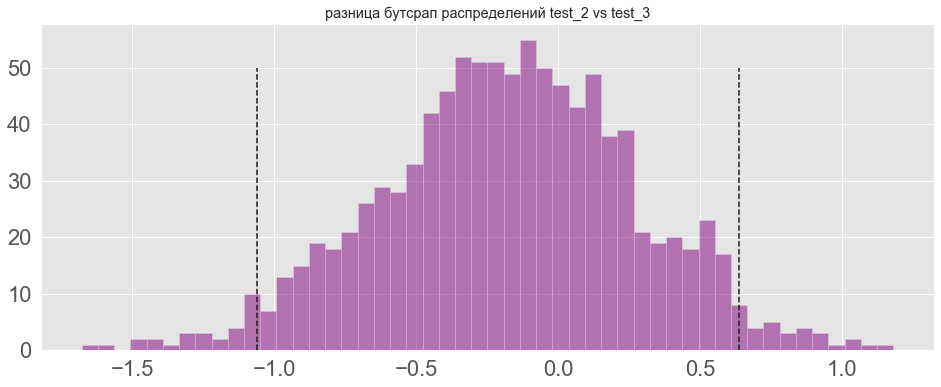

In [46]:
#разница средних бутстрап распределений test_2 vs test_3 
cl_pvalue = pd.Series(pd.Series(boot_data_2) - pd.Series(boot_data_3)).quantile([left_cl,right_cl])
plt.hist(pd.Series(boot_data_2) - pd.Series(boot_data_3), bins=50, alpha=0.5, color='purple')
plt.title('разница бутсрап распределений test_2 vs test_3')
plt.vlines(cl_pvalue,ymin=0,ymax=50,linestyle='--');

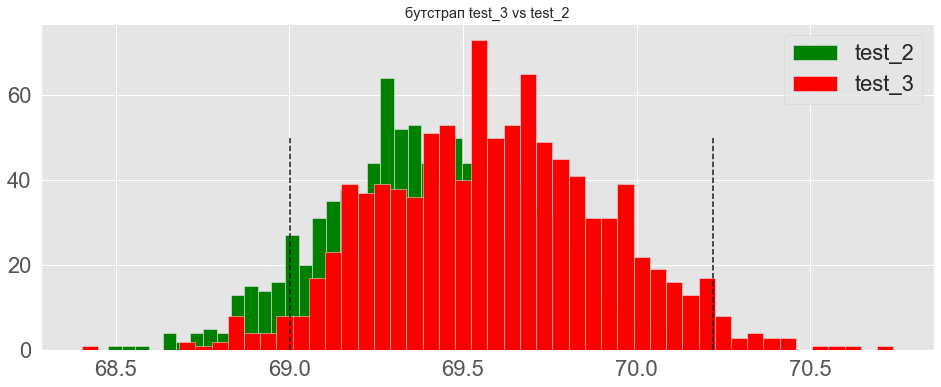

In [47]:
plt.hist(pd.Series(boot_data_2), bins=50, alpha=1, label='test_2', color='green')
plt.hist(pd.Series(boot_data_3), bins=50, alpha=1, label='test_3', color='red')
plt.style.use('ggplot')
plt.vlines(cl_3,ymin=0,ymax=50,linestyle='--')
plt.title('бутстрап test_3 vs test_2')
plt.legend();

**Комментарий**


Среднее test_2 незначимо отличается от среднего test_3 